In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from datetime import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf

In [14]:
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('./bitcoin_20120101_to_20181031.csv')
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,
2011-12-31,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119578,5.208159


#### visualize the average price

In [16]:
df_month = df.resample('M').mean()
df_quarter = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

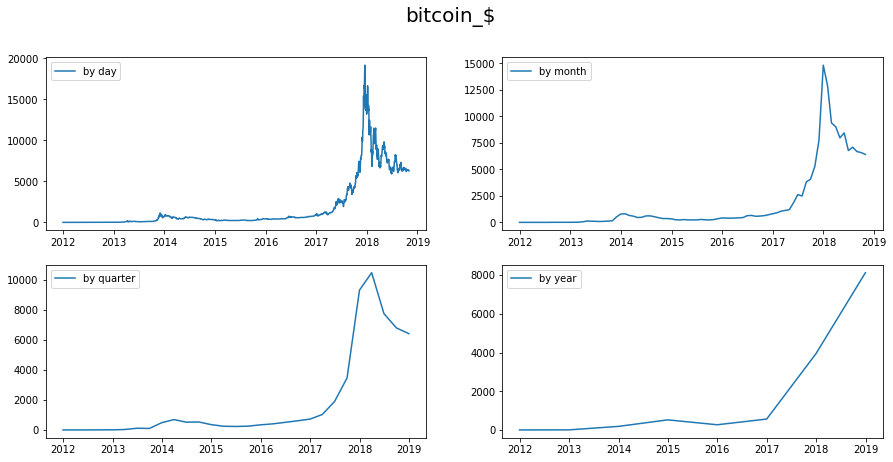

In [17]:
fig = plt.figure(figsize = [15,7])
plt.suptitle('bitcoin_$',fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price,'-',label='by day')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price,'-',label='by month')
plt.legend()
plt.subplot(223)
plt.plot(df_quarter.Weighted_Price,'-',label='by quarter')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price,'-',label='by year')
plt.legend()
plt.show()

#### determine d

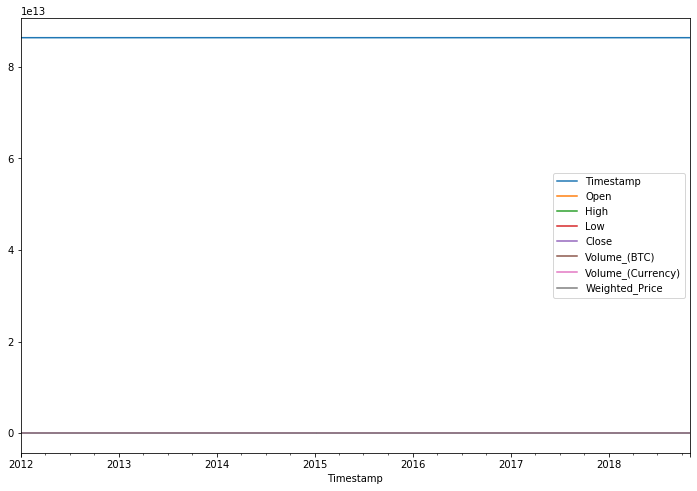

In [18]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(111)
diff1 = df.diff(1)
diff1.plot(ax=ax1)

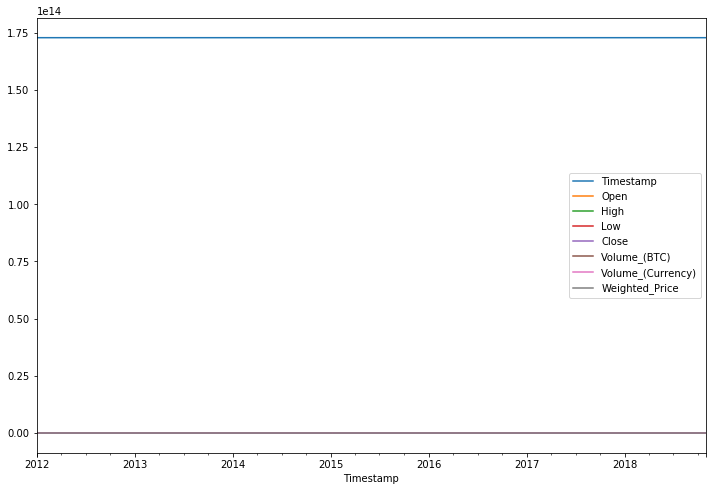

In [19]:
fig=plt.figure(figsize=(12,8))
ax2=fig.add_subplot(111)
diff2 = df.diff(2)
diff2.plot(ax=ax2)

#### They are similar, apply d = 1

#### train ARIMA model

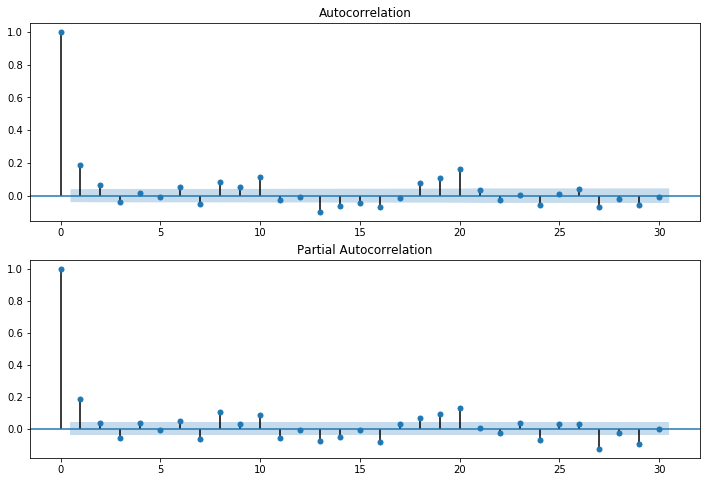

In [20]:
df1=df.diff(1)
df1.dropna(inplace=True)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df1.Weighted_Price,lags=30,ax=ax1)

ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df1.Weighted_Price,lags=30,ax=ax2)

In [21]:
# set p and q
ps = range(0,3)
qs = range(0,3)
parameters = product(ps,qs)
parameters_list = list(parameters)

In [32]:
df1_month = df1.resample('M').mean()

In [33]:
results =[]
best_aic = float('inf')
for param in parameters_list:
    try:
        model = ARMA(df1_month.Weighted_Price,order=(param[0],param[1])).fit()
    except ValueError:
        print('ValueError',param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_aic = aic
        best_param = param
        best_model = model
    results.append([param,model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters','aic']
print('the best model:',best_model.summary())

ValueError (1, 1)
ValueError (1, 2)
the best model:                               ARMA Model Results                              
Dep. Variable:         Weighted_Price   No. Observations:                   82
Model:                     ARMA(2, 2)   Log Likelihood                -392.126
Method:                       css-mle   S.D. of innovations             28.151
Date:                Sun, 10 Oct 2021   AIC                            796.253
Time:                        17:22:16   BIC                            810.693
Sample:                    01-31-2012   HQIC                           802.050
                         - 10-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.4319      3.355      0.725      0.471      -4.143       9.007
ar.L1.Weighted_Price    -0.8841      0.092     -9

#### bitcoin predict

In [86]:
df1_month2 = df1_month[['Weighted_Price']]
date_list=[datetime(2018, 11, 30), 
           datetime(2018, 12, 31), 
           datetime(2019, 1, 31), 
           datetime(2019, 2, 28), 
           datetime(2019, 3, 31), 
           datetime(2019, 4, 30), 
           datetime(2019, 5, 31), 
           datetime(2019, 6, 30)]

In [87]:
pre = pd.DataFrame(index=date_list, columns= df1_month.columns)
df1_month2 = pd.concat([df1_month2, pre])
df1_month2['Predicts'] = best_model.predict(start=0, end=90)

In [100]:
#new = pd.Series([df_month.Weighted_Price[0]], index=[df_month.Weighted_Price.index[0]]) .append(df1_month['Weighted_Price']).cumsum()

In [118]:
df1_month2_pre = pd.Series([df_month.Weighted_Price[82]],index=[df_month.Weighted_Price.index[82]]).append(df1_month2.Predicts[83:90]).cumsum()

In [124]:
aa = pd.concat([df_month.Weighted_Price,df1_month2_pre])

In [125]:
model = ARIMA(aa,order=(2,1,2))
result = model.fit(disp=-1)

In [126]:
result.conf_int()

,0,1
const,-138.633288,281.601041
ar.L1.D.y,-1.668072,0.768939
ar.L2.D.y,-1.060206,-0.070774
ma.L1.D.y,-0.571535,1.892386
ma.L2.D.y,-0.112638,1.264327


<Figure size 1440x504 with 0 Axes>

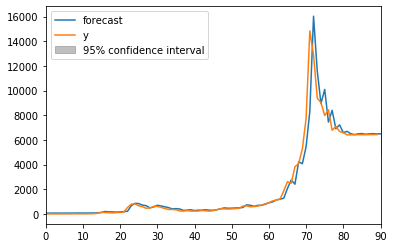

In [127]:
plt.figure(figsize=(20,7))
fig = result.plot_predict(1, 91)
plt.show()